# Ensembles
Lecture recap
1. Combine many weak algorithms into one strong
2. Most of them use decision trees as base estimators - they are fast, invariant to scaling, and handle features of different nature well
3. For problems like Higgs (small number of features of different origin) ensembles of decision trees is state-of-the-art.


Let's try them out on simple synthetic data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

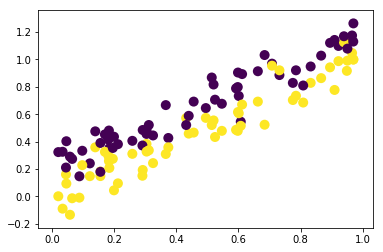

In [2]:
np.random.seed(42)
x_space = np.random.uniform(0, 1, size=60)
y0 = x_space + 0.2 + np.random.normal(size=len(x_space), scale=0.1)
y1 = x_space + np.random.normal(size=len(x_space), scale=0.1)
shuffle = np.random.permutation(2*len(x_space))


X = np.concatenate((np.concatenate((x_space, x_space))[:, np.newaxis],
                          np.concatenate((y0, y1))[:, np.newaxis]), axis=1)[shuffle]

y = np.concatenate((np.zeros(len(y0)), np.ones(len(y1))))[shuffle]

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='none', s=100);

In [3]:
from sklearn.preprocessing import scale
X = scale(X)


## RandomForest
1. Uses bagging + random subspace method on Decision Trees
2. Isn't prone to overfitting
3. Easily parallelized

Let's see how decision surface for ReandomForest changes with incerase in the number of estimators.

In [4]:

n_classes = 2
plot_colors = "bry"
plot_step = 0.02

def plot_decision_surface(clf, X, y):
    """Draws colored rectangles representing decision rule"""
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

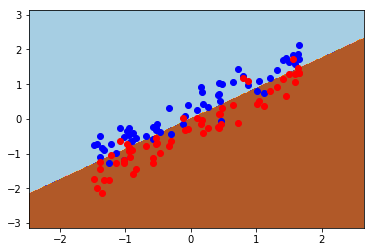

In [5]:
from sklearn.linear_model import LogisticRegression
plot_decision_surface(LogisticRegression().fit(X,y), X, y)


In [6]:
from sklearn.ensemble import RandomForestClassifier

estimators_set = (1, 2, 3, 4, 5, 10, 20, 30, 50, 100)


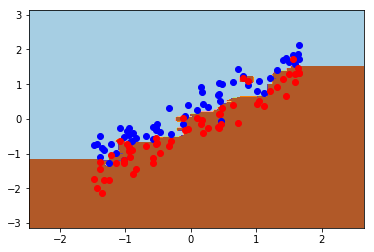

In [8]:
#plot decision surface of random forest with different number of estimators
tree = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
tree.fit(X, y)
plot_decision_surface(tree, X, y)

## Boosting
1. Ensemble members are trained consequently to compensate for imperfection
2. Will overfit, especially if strong base algorithms are used
3. Can be parallelized (Google is your friend)

# Gradient boosting

In [9]:
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
tracks_dataset = "../../../comp-1/data/DS_1_train.csv"
electrons_dataset = "../../comp-1/data/DS_1_electron_train.csv"

In [10]:
features = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']
tracks = pd.read_csv(tracks_dataset, index_col="index", usecols=[
    'index'] + features + ['signal'])
train, test = train_test_split(tracks, random_state=14)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [38]:
X_train = train[features]
X_test = test[features]
Y_train = train['signal']
Y_test = test['signal']

In [41]:
xgb = xgboost.XGBClassifier(n_jobs=-1, n_estimators=200).fit(X_train,Y_train)

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test.signal, xgb.predict_proba(X_test)[:,1])

0.96632778465372104

## Feature importances

In [17]:
xgb.feature_importances_

array([ 0.05      ,  0.        ,  0.30000001,  0.12857144,  0.30000001,
        0.22142857], dtype=float32)

In [ ]:
fig, ax = plt.subplots()
ax.bar(list(range(len(xgb.feature_importances_))), xgb.feature_importances_)
ax.set_xticklabels([""] + features)
ax.set_ylabel("Feature importance");

# Custom ensembles

[A classic Kaggle technique](https://mlwave.com/kaggle-ensembling-guide/)

## Level 1 - simple voting

In [47]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = [xgboost.XGBClassifier(n_jobs=-1, n_estimators=20, random_state=4325),
          xgboost.XGBClassifier(n_jobs=-1, n_estimators=20, random_state=422),
          RandomForestClassifier(n_jobs=-1, n_estimators=20, random_state=35252),
#          Ridge(random_state=141),
          LogisticRegression(n_jobs=-1, random_state=21459)]



#... something wrong with one of the models...

In [48]:
for model in models:
    model.fit(X_train, Y_train)

In [49]:
for model in models:
    print("Model = ",model)
    print("AUC = ",roc_auc_score(test.signal, model.predict_proba(X_test)[:, 1]))

('Model = ', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=4325, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))
('AUC = ', 0.91427486745433828)
('Model = ', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=422, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))
('AUC = ', 0.91427486745433828)
('Model = ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_featur

In [53]:
def predict(models, X):
    """
    Voting classifier that works by averaging predicted probabilities among models.
    Reminder: you can use model.predict_proba(X) to get probabilities for each class
    """

    preds = []
    for model in models:
        preds.append(model.predict_proba(X))
    return np.mean(preds,axis=0)
    
prediction = predict(models,X_test)

assert prediction.ndim==2 and prediction.shape[1]==2, "Predicted probabilities must be a matrix[n,2]"
assert np.allclose(prediction.sum(axis=-1),1)

In [54]:
roc_auc_score(Y_test, predict(models,X_test)[:,1])

0.94513045129891216

## Level 1.5 - simple voting of less correlated algorithms


In [ ]:
roc_auc_score(test.signal, np.average(predictions[1:], axis=0))

## Bonus Level - weighting proportional to model quality

You can also average your models with unequal weights: better models get more weights, worse models are less significant

In [ ]:
weights = <compute ROC AUC score for each model on validation>

In [ ]:
def predict_weighted(models, X, weights):
    """
    Voting classifier that works by averaging predicted probabilities among models.
    Note: you can use np.average(...,weights=weights) to get weighted average (or do it manually)
    """

    <implement prediction by voting among models>
    
    return <your code: array of averaged probabilities>

In [ ]:
# Even better
roc_auc_score(Y_test,predict_weighted(models,X_test,weights))

In [ ]:
#Bonus bonus: try using different weights. For example, downweight logistic regression.

## Level 2 - stacking

In [73]:
train_level_one, train_level_two = train_test_split(train, random_state=517)

X_train_one = train_level_one[features]
X_train_two = train_level_two[features]
Y_train_one = train_level_one['signal']
Y_train_two = train_level_two['signal']


In [55]:
models = [xgboost.XGBClassifier(n_jobs=-1, n_estimators=100, random_state=422),
          RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=35252),
          #<any other model you want>
          ]


In [60]:
for model in models:
    model.fit(X_train_one, Y_train_one)

In [77]:
level_two_predictions = np.array([model.predict_proba(X_train_two)[:,1] for model in models]).T

In [76]:
print(level_two_predictions.shape, X_train_one.shape, Y_train_one.shape)

((631786, 2), (631786, 6))


In [78]:
stacked_model = xgboost.XGBClassifier(n_jobs=-1).fit(level_two_predictions, Y_train_two)

In [80]:
level_two_predictions_test = np.array([model.predict_proba(X_train_one)[:,1] for model in models]).T
final_predictions_test = stacked_model.predict_proba(level_two_predictions_test)


# Exercises

**Exercise 1** Plot learning curve for XGBoost. On X axis there should be the training dataset size, on Y axis - cross-validation performance.

Learning curve is useful when selecting a dataset size for experimentation as execution time grows with the dataset size.
1. http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.validation_curve.html#sklearn.learning_curve.validation_curve
2. Bonus points for plotting errors, for example with http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.fill_between

**Exercise 2** Check whether feature importance as reported makes sense. Try removing each feature, plot the quality on cross-validation as a function of the feature removed.

**Exercise $\infty$** Win the Kaggle! A few suggestions to try:
 1. Experiment to find the best parameters (see next seminar for the advanced techniques)
 2. Use multiple classifiers (possibly on different features) and average the predictions
 3. Use stacking